# Analyzing the growth dynamics of bacteria during enviornmental shifts

This jupyter notebook introduces the code used in Balakrishnan et al. to model growth transitions. Code to plot results is included. All plots are stored into the subfolder 'plot_output'. Make sure that subfolder excist before running script.

Jonas Cremer
jbcremer@stanford.edu
10/24/2021


In [1]:
#start Python session

#general
import numpy as np
import pandas as pd

#for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#to obtain numerical solution of equations
import scipy.integrate as spi
import matplotlib.pyplot as plt
from scipy.integrate import odeint #module to solve ODEs

from sympy import *

# Define the equations

The RHS of the differential equations are described in the following. Two scenarios are considered:
- simple growth scenario with one nutrient source
- two nutrient sources



In [2]:
#varialbes. The model variables are handled in the list var as follows:
#var[0]: protein mass
#var[1]: precursors for translation (charged tRNA)
#var[2]: external nutrient source
#var[3]: enzymes for nutrient source 1
#var[4]: additional nutrient source
#var[5]: enzymes for nutrient source 2

#parameters. model parameters are:
#a0: the Michaelis menten constant describing the concentration of precursors below which translation rates substantially fall. This value can be estimated from published observations
#Y and YB: the yield factors - measured in independent experiments
#Km and KmB: the Monod constant describing the nutrient concentrations below which growth falls - measured in independent experiments.
#fracactivev: the fraction of ribisomes which are active and ready for translation

#kA, kAB: the contribution of metabolic enzymes to the supply of new precursors. This value is hard to estimate and will be fixed here.

#the allocation coefficients:
#phiR allocation towards ribosomes during steady state growth
#phi allocation towards metabolic enzymes (nutrient 1). Formula assumes constant allocation as long as nutrient 1 is available (substrate dependent regulation)
#phiNBglu: allocation towards metabolic enzymes (nutrient 2) during steady steady when growing in glucose
#phiNB: allocation towards metabolic enzyems (nutrient 2) once glucose runs out
#phiNBmax the max. fraction of enzymes reached. 
#the model does not explicitely consider the change of ribosomal content during the shift. phiR will follow pre-shift expression. 

#Full model: to study growth on two nutrient sources
def dynamicalgrowthmodel_withsecondnutrientsource(var,t0,kR,fracactivev,ka,kaB,phiR,phiN,phiNB,phiNBglu,phiNBmax,a0,Y,Km,YB,KmB):
    nua=2.
    dMdt=(3600*kR/7459)*fracactivev*phiR*var[0]*(np.power(var[1]/var[0],nua)/(np.power(var[1]/var[0],nua)+np.power(a0,nua))) #the conversion 3600/7459 translates measured translation speeds (unit: aa/s) into a translation rate (unit 1/h). 7450 is the number of all aa in an E. coli ribosome. 3600 is to go from seconds to hours.
    enzymesynth1=phiN*dMdt*var[2]/(var[2]+Km)
    enzymesynth2=dMdt*(phiNBglu*(np.power(var[2],2.)/(np.power(var[2],2.)+np.power(Km/100.,2.)))+phiNB*(1-np.power(var[2],2.)/(np.power(var[2],2.)+np.power(Km/100.,2.))))*(1.-np.power(var[5]/var[0],2.)/(np.power(phiNBmax,2.)+np.power(var[5]/var[0],2.)))
    influx1= ka*var[3]*var[2]/(var[2]+Km)
    influx2= kaB*var[5]*var[4]/(var[4]+KmB)
    return [dMdt,influx1+influx2-dMdt,-influx1/Y,enzymesynth1,-influx2/YB,enzymesynth2]
   

#Simple model: just growth on one nutrient source (no shift)
def dynamicalgrowthmodel(var,t0,kR,fracactivev,ka,phiR,phiN,a0,Y,Km):
    nua=2.
    dMdt=(3600*kR/7459)*fracactivev*phiR*var[0]*(np.power(var[1]/var[0],nua)/(np.power(var[1]/var[0],nua)+np.power(a0,nua)))
    enzymesynth1=phiN*dMdt
    influx1= ka*var[3]*var[2]/(var[2]+Km)
    return [dMdt,influx1-dMdt,-influx1/Y,enzymesynth1]
    
MODfactor=(118.9/6.32/np.power(10,20)/0.63)/0.5 #to see abundance in OD we have to calculate back from amino acids (protein biomass of cells) to optical density OD (dry mass of cells)
#118.9 mg/mmol average weight amino acid
#MODfactor*M gives results in OD
#conversions: weight AA=120 mg/mmol
#0.5 mg/OD ml conversion factor to go from weight to OD.
#factor 0.63 accounting for proteins making up only a fraction of all cell mass

# Solve the euqations

Solving the equations and ploting the resulting growth dynamics for one growth transition (specific set of parameters)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


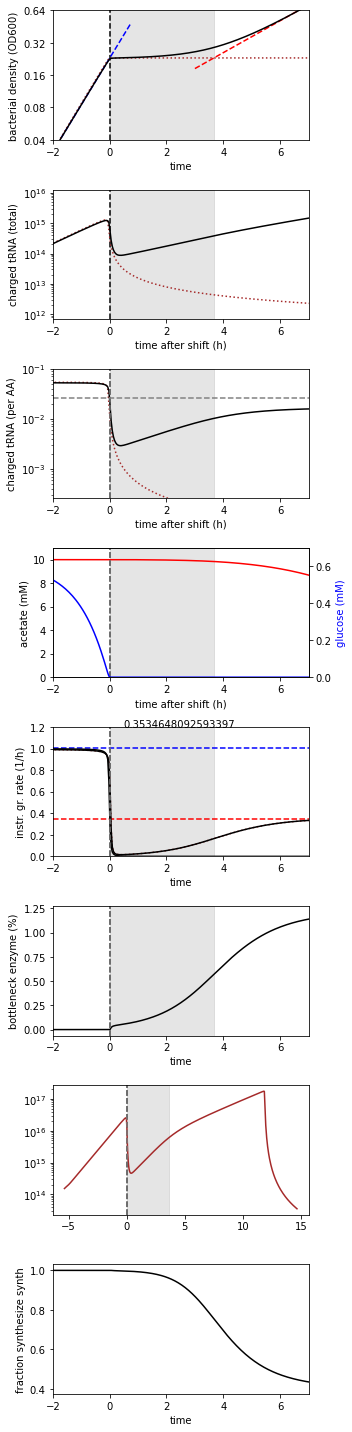

In [9]:

#define parameters
a0=0.0013*20
kR=20 #translation rate in unites AA/second 
ka=2.4 #rate describing how metabolic enzymes provide precursors for growth on glucose (nutrient 1). This rate comes from steady state measurements.
kaB=30 #rate describing how metabolic enzymes required for acetate utiliziation provide precursors for growth on acetate (nutrient 2). This rate can be fixed by fitting the steady state solution for growth on acetate.
fracactivev=0.65 #fraction of active ribosomes directly involved in translation. This is usually assumed to be constant and can be estimated by polysome profiling, although data remains a bit inconclusive. 

#set allocation parameters
#during steady growth on glucose (nutrient 1):
phiO=0.35
phiR=0.2
phiN=1-phiR-phiO
phiNBglu=0 #expression of metabolic enzymes for acetate (nutrient 2) utilization already before glucose (nutrient 1) runs out

#then during the growth transition (once glucose runs out). These values are guided by the transcriptomics measurements.
phiNB=0.03 #how much is used for nutrients after run out of glucose
phiNBmax=.01 #the maximum level reached. 

xlim=[-2,7]

#set initial conditions
M0=0.001/MODfactor #start with low number
Ma0=0.0001/MODfactor #start with low number
N0=.61 #unites mili molar
#enzymes for nutrient source
ME0=M0*phiN
#
N0B=10 #second nutrient source
ME0B=0

#set yield and Km parameters of uptake
Y=0.377/MODfactor
#0.16*6.32*np.power(10,17) #amino acids per glucose molecule
#lets say we have 1ml culture and glucose concentration in units mmol/l
#so we have to include a factor: mmol/l*10^-3 l= 10^-6 mol
Km=0.005 # (unit mmol)

#for 2nd carbon source
YB=Y
KmB=Km
plateau=.23

# solve ODE
timestepsout=500
tend=20
deltat=tend/timestepsout
t = np.linspace(0,tend,timestepsout) #units in hour
output = odeint(dynamicalgrowthmodel,[M0,Ma0,N0,ME0],t,args=(kR,fracactivev,ka,phiR,phiN,a0,Y,Km)) 


#solve further, with 2nd nutrient source
output2=odeint(dynamicalgrowthmodel_withsecondnutrientsource,[M0,Ma0,N0,ME0,N0B,ME0B],t,args=(kR,fracactivev,ka,kaB,phiR,phiN,phiNB,phiNBglu,phiNBmax,a0,Y,Km,YB,KmB))

#calculate lagtime
#fit exp. curve first growth
indxr=np.argwhere(np.logical_and(MODfactor*output2[:,0]>0.04,MODfactor*output2[:,0]<0.2))
x=t[indxr].flatten()
y=MODfactor*output2[indxr,0]
fitc=np.polyfit(x,np.log(y),1)
trfirst=np.linspace(-2,1,100)

#fit exp. curve 2nd growth
indxr=np.argwhere(np.logical_and(MODfactor*output2[:,0]>2*plateau,MODfactor*output2[:,0]<2))
x=t[indxr].flatten()
y=MODfactor*output2[indxr,0]
fitc2=np.polyfit(x,np.log(y),1)
tr=np.linspace(5.5,20,1000)
t2=(np.log(plateau)-fitc2[1])/fitc2[0]

#calculate lag-time by calculating when exponential curves fit the plateau value
t1=(np.log(plateau)-fitc[1])/fitc[0]

#####
#plot results
#prepare the different variables the model considers including biomass, precursors, etc
#####

colorgluonly='brown'
tlabel='time after shift (h)'

#ax=plt.axes(3)
fig, axs = plt.subplots(8,figsize=(5,20))
axs[0].plot(t-t1,MODfactor*output[:,0],c=colorgluonly,zorder=-1,ls=":")
axs[0].plot(t-t1,MODfactor*output2[:,0],c='k')
axs[0].set_xlabel('time')
axs[0].set_ylabel('bacterial density (OD600)')
axs[0].set_yscale("log")
axs[0].set_yticks([0.04,0.08,0.16,0.32,0.64,1.28])
axs[0].set_yticklabels([0.04,0.08,0.16,0.32,0.64,1.28])
axs[0].minorticks_off()
#axs[0].axhline(plateau,ls='--')
axs[0].set_ylim(0.04,.64)
axs[0].set_xlim(xlim)
tr22=np.linspace(3,10,1000)+t1
tr33=np.linspace(-2,0.75,1000)+t1
axs[0].plot(tr22-t1,np.exp(fitc2[0]*tr22+fitc2[1]),ls='--',color='r',zorder=-2)
axs[0].plot(tr33-t1,np.exp(fitc[0]*tr33+fitc[1]),ls='--',color='b',zorder=-2)

for ilcc in range(0,7):
    axs[ilcc].axvspan(0,t2-t1,color='gray',alpha=0.2,zorder=-5)
    axs[ilcc].axvline(0,color='k',zorder=-3,ls='--')


axs[1].plot(t-t1,output[:,1],c=colorgluonly,zorder=-2,ls=':')
axs[1].plot(t-t1,output2[:,1],c='k',ls='-')
axs[1].set_xlabel(tlabel)
axs[1].set_ylabel('charged tRNA (total)')
axs[1].set_yscale("log")
axs[1].set_xlim(xlim)

axs[2].plot(t-t1,output[:,1]/output[:,0],c=colorgluonly,ls=":")
axs[2].plot(t-t1,output2[:,1]/output2[:,0],c='k')
axs[2].set_xlabel(tlabel)
axs[2].set_ylabel('charged tRNA (per AA)')
axs[2].set_yscale("log")
axs[2].axhline(a0,ls='--',color='gray')
axs[2].set_ylim(a0/100,0.1)
axs[2].set_xlim(xlim)

axs[3].plot(t-t1,output2[:,4],c='r',label='acetate')
#axs[3].plot(t-t1,output2[:,4],c='r',label='acetate')
axs[3].set_xlabel(tlabel)
axs[3].set_ylabel('acetate (mM)')
axstw=axs[3].twinx()
axstw.plot(t-t1,output2[:,2],c='b',label='acetate')
axstw.set_ylabel("glucose (mM)",color='b')
axstw.set_ylim(0,0.7)
axs[3].set_ylim(0,11)
axs[3].set_xlim(xlim)

#instantaneous growth rate
diff=np.diff(output[:,0], n=1,prepend=0)
axs[4].plot(t-t1,diff/output[:,0]/deltat,c='k')

diff2=np.diff(output2[:,0], n=1,prepend=0)
axs[4].plot(t-t1,diff2/output2[:,0]/deltat,c='k')
axs[4].set_xlabel('time')
axs[4].set_ylabel('instr. gr. rate (1/h)')
axs[4].set_ylim(0,1.2)
axs[4].plot(t-t1,diff2/output2[:,0]/deltat,c=colorgluonly,ls=":",zorder=-1)
axs[4].axhline(fitc2[0],ls='--',color='r',zorder=-2)
axs[4].axhline(fitc[0],ls='--',color='b',zorder=-2)
axs[4].set_xlim(xlim)

#find last point where 2nd nutrient source is above certain value
indxm=np.nanmax(np.argwhere(output2[:,4]>0.5))
axs[4].axvline(t[indxm]-t1,ls='--',c='gray')
axs[4].text(0.5,1.2,diff2[indxm]/output2[indxm,0]/deltat)

#enzymatic levels.
axs[5].plot(t-t1,100*output2[:,5]/output2[:,0],c='k',ls='-')
axs[5].set_xlabel('time')
axs[5].set_ylabel('bottleneck enzyme (%)')
#axs[5].axhline(phiNBmax,c='gray',ls='--')
#axs[5].set_yscale("log")
axs[5].set_xlim(xlim)

#plot how fully on is enzyme synthesis.....
axs[7].plot(t-t1,(1.-np.power(output2[:,5]/output2[:,0],2.)/(np.power(phiNBmax,2.)+np.power(output2[:,5]/output2[:,0],2.))),c='k')
axs[7].set_xlabel('time')
axs[7].set_ylabel('fraction synthesize synth')
axs[7].set_xlim(xlim)

#enzymatic levels.....
nua=2.
dMdtc=(3600*kR/7459)*fracactivev*phiR*output2[:,0]*(np.power(output2[:,1]/output2[:,0],nua)/(np.power(output2[:,1]/output2[:,0],nua)+np.power(a0,nua)))
axs[6].plot(t-t1,dMdtc,c='brown')
#axs[6].set_xlabel('time')
#axs[6].set_ylabel('enzymatic levels (fraction)')
#axs[6].axhline(phiNB,c='gray',ls='--')
axs[6].set_yscale("log")

axs[2].axvline(0,ls='--',color='gray')
axs[3].axvline(0,ls='--',color='gray')
axs[4].axvline(0,ls='--',color='gray')
axs[5].axvline(0,ls='--',color='gray')
axs[6].axvline(0,ls='--',color='gray')

fig.tight_layout()
fig.savefig("plot_output/modelsln.pdf")


# Investigating how parameters change growth transition. 

Probing particularly how lag-times are changing with the allocation of ribosomes to the enzymes required to grow on new carbon source

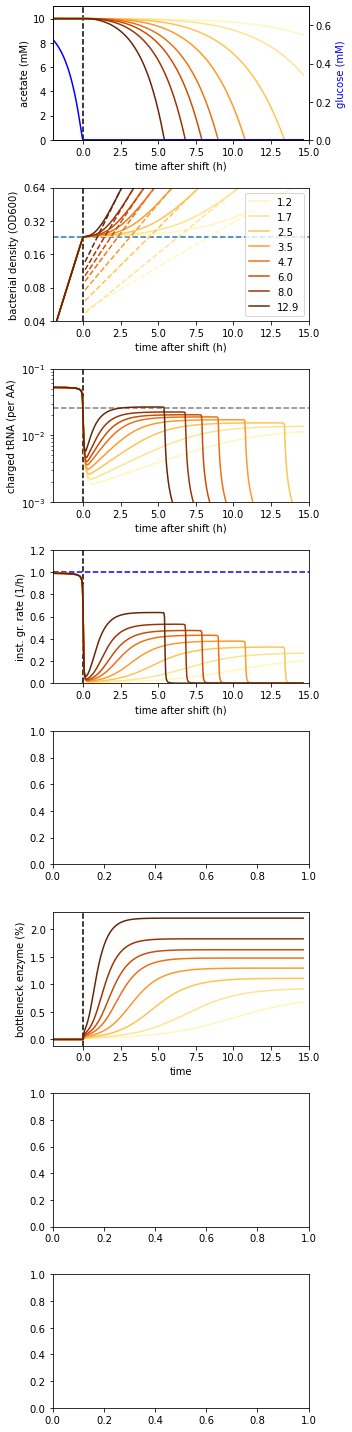

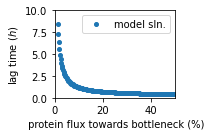

In [8]:

#################################
#run simulations again but vary the allocation behavior during the growth transtion
#################################

fig, axs = plt.subplots(8,figsize=(5,20))
axs[0].set_xlabel(tlabel)
axs[0].set_ylabel('acetate (mM)')
axs[0].set_ylim(0.0,11)
axs[0].set_xlim(-2,15)
axs[0].axvline(0,ls='--',color='k')

axs[1].set_xlabel(tlabel)
axs[1].set_ylabel('bacterial density (OD600)')
axs[1].set_yscale("log")
axs[1].set_yticks([0.04,0.08,0.16,0.32,0.64,1.28])
axs[1].set_yticklabels([0.04,0.08,0.16,0.32,0.64,1.28])
axs[1].minorticks_off()
axs[1].axhline(plateau,ls='--')
axs[1].set_ylim(0.04,.64)
axs[1].set_xlim(-2,15)
axs[1].axvline(0,ls='--',color='k')

axs[2].set_xlabel(tlabel)
axs[2].set_ylabel('charged tRNA (per AA)')
axs[2].set_yscale("log")
axs[2].axhline(a0,ls='--',color='gray')
axs[2].set_ylim(0.001,0.1)
axs[2].set_xlim(-2,15)
axs[2].axvline(0,ls='--',color='k')

axs[3].set_xlabel(tlabel)
axs[3].set_ylabel('inst. gr. rate (1/h)')
axs[3].set_ylim(0,1.2)
axs[3].set_xlim(-2,15)
axs[3].axvline(0,ls='--',color='k')

axs[5].set_xlabel('time')
axs[5].set_ylabel('bottleneck enzyme (%)')
axs[5].set_xlim(-2,15)
axs[5].axvline(0,ls='--',color='k')
colorl=['#fff7bc','#fee391','#fec44f','#fe9929','#ec7014','#cc4c02','#993404','#662506']
markerl=['<','>','^','v','o','s','h','d']

plotselect=[3,5,8,12,17,22,30,50]
listparv=np.linspace(0.005,0.5,200)


lagtimel=[]
clorcc=-1
for ie in range(0,listparv.shape[0]):
    phiNB=listparv[ie]
    output2=odeint(dynamicalgrowthmodel_withsecondnutrientsource,[M0,Ma0,N0,ME0,N0B,ME0B],t,args=(kR,fracactivev,ka,kaB,phiR,phiN,phiNB,phiNBglu,phiNBmax,a0,Y,Km,YB,KmB))
    
    #calculate lagtime
    #fit exp. curve first growth
    indxr=np.argwhere(np.logical_and(MODfactor*output2[:,0]>0.04,MODfactor*output2[:,0]<0.2))
    x=t[indxr].flatten()
    y=MODfactor*output2[indxr,0]
    fitc=np.polyfit(x,np.log(y),1)
    trfirst=np.linspace(-2,1,100)
    t1=(np.log(plateau)-fitc[1])/fitc[0]

    try:
        indxr=np.argwhere(np.logical_and(MODfactor*output2[:,0]>2*plateau,MODfactor*output2[:,0]<2))
        x=t[indxr].flatten()
        y=MODfactor*output2[indxr,0]
        fitc2=np.polyfit(x,np.log(y),1)
        tr=np.linspace(5.5,20,1000)
        t2=(np.log(plateau)-fitc2[1])/fitc2[0]
        t2=(np.log(plateau)-fitc2[1])/fitc2[0]
        lagtimel.append(t2[0]-t1[0])
    except:
        lagtimel.append(np.nan)
    
    #plot od solution over time
    #sensity
    if ie in plotselect and clorcc <= 10:
        clorcc=clorcc+1
        colorc=colorl[clorcc]
        markerc=markerl[clorcc]
        if clorcc==0:
            axsTW=axs[0].twinx()
            axsTW.set_ylim(0,.7)
            axsTW.set_ylabel("glucose (mM)", color='b')
            axsTW.plot(t-t1,output2[:,2],ls='-',color='b')
        axs[0].plot(t-t1,output2[:,4],ls='-',color=colorc)
        axs[1].plot(t-t1,MODfactor*output2[:,0],ls='-',color=colorc,label=round(100*listparv[ie],1))
        axs[1].plot(tr-t1,np.exp(fitc2[0]*tr+fitc2[1]),ls='--',color=colorc)
        axs[2].plot(t-t1,output2[:,1]/output2[:,0],ls='-',color=colorc)
        axs[5].plot(t-t1,100*output2[:,5]/output2[:,0],c=colorc,ls='-')
        #IGR
        diff2=np.diff(output2[:,0], n=1,prepend=0)
        axs[3].plot(t-t1,diff2/output2[:,0]/deltat,c=colorc)
        if clorcc==0:
            axs[3].axhline(fitc[0],ls='--',color='b')
        
#plot 
axs[1].legend()
fig.tight_layout()
fig.savefig("plot_output/scan_alpha.pdf")

fig, axs = plt.subplots(1,figsize=(2.5,2))

#plot how lag time is changing
axs.set_ylabel("lag time $(h)$")
axs.set_xlabel(" protein flux towards bottleneck (%)")
axs.plot(listparv*100,lagtimel,marker='o',ls='',label='model sln.',ms=4)
axs.set_ylim(0,10)
axs.set_xlim(0,50)
axs.legend()

fig.tight_layout()
fig.savefig("plot_output/vsscan.pdf")